# Credit Card Fraud Detection
### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

** Run the following code to import the librairies

In [ ]:
# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Object
In this notebook, we will be focusing on dealing with the **imbalanced dataset**, which is our case. 

The obvious challenge of solving class imbalance imbalance is the lack of data for one of the classes. For instance, many datasets are such that there are 95% samples for class 1 and the rest for class 0 and since data is what algorithm needs to learn, fails to recognize the minority. In this case, choice of loss function is necessary and it should be more sensitive to class 1 than class 0.

Most classification datasets don’t have exactly equal numbers of records in each class, but a small difference doesn’t matter as much. This class imbalance problem can occur in binary classification problems as well as multi-class classification problems, but most techniques can be used on either.

## In this first step you are going to analyze the dataset
#### 1. Import your dataset and visualize the first five rows

In [ ]:
path = '/content/drive/MyDrive/Course v2/B1. Machine Learning Deep Learning/B1.6 Fraud Detection/creditcard.csv'


In [ ]:
df = pd.read_csv(path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### 2. Is there any Null value in your dataset?

In [ ]:
# Good No Null Values!
df.isnull().sum().max()

0

#### 3. Display the columns of the dataset

In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Note: Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

#### 4. Calculate amounts of each class

In [ ]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Do you have any Comments:

Note: Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

#### 5. Let's visualize our results

In [ ]:
def visualize_data(data):
  colors = ["#0101DF", "#DF0101"]
  sns.countplot('Class', data=df, palette=colors)
  plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

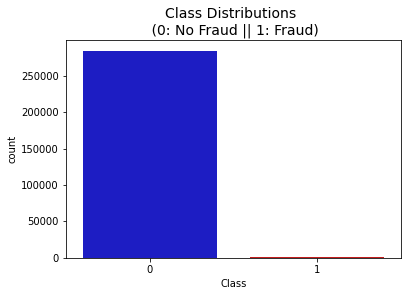

In [ ]:
visualize_data(df)

Check the ratio of both classes:

In [ ]:
from sklearn.utils import compute_class_weight

# calculate the class weight by providing the 'balanced' parameter.
class_weight = compute_class_weight('balanced', df.Class.unique() , df.Class)

# print the result
print(class_weight)
print("No.No_Fraud : No.Fraud ---", round(class_weight[1] / class_weight[0]) )

[  0.50086524 289.43800813]
No.No_Fraud : No.Fraud --- 578


As you can see here, we have a highly imbalanced data: the amount of no-fraud cases is nearly 578 times the amount of fraud cases. If we don't deal with it, it will post a big problem to our machine learning model, as it can't detect the fraud cases, because we feed it with the vast majority of non-fraud data

# Scaling

Before we deal with the imblanace problem, let's scale the data first

In [ ]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# drop the original columns that we put our scalers on
df.drop(['Time','Amount'], axis=1, inplace=True)

In [ ]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [ ]:
# let's shuffule our dataset first:
df = df.sample(frac=1)
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
65419,-0.097813,-0.910521,-0.362240,0.772002,1.850464,0.792450,0.185240,0.201619,0.702099,-0.116111,0.169838,-0.283189,-0.666117,0.244096,-0.065730,-0.517103,-0.373276,-0.859058,0.164418,-0.736311,-0.249592,-0.079161,-0.016425,0.335484,-0.250948,0.100263,0.159995,-0.350899,-0.210759,-0.202297,0
5484,-0.307413,-1.880280,-1.317304,0.123519,2.457654,2.716571,0.814807,0.191741,-0.999622,0.384125,0.928563,0.548064,1.206366,-2.258819,1.186063,1.203716,-1.488013,0.526272,0.211213,0.960991,0.193159,-0.123614,-0.165697,0.045674,-0.213357,-0.036051,-0.692173,-0.075011,0.434823,0.163794,0
254230,-0.027947,1.301825,-0.479119,-0.552405,-0.336637,-3.086234,1.316347,3.850850,-1.605479,1.705125,-0.326634,-0.203615,-0.478357,-0.489649,0.054793,-0.467950,-0.103685,1.716843,-0.168154,-1.108581,-0.527823,0.142023,0.264523,0.520943,0.078099,0.695098,-0.145361,-0.320328,0.145715,-0.090780,0
125958,2.962342,-0.356676,0.850054,-1.201491,-0.237813,-0.607297,-0.627241,0.100217,-0.097422,0.010931,-1.379790,0.674089,1.702221,0.833149,0.395394,0.499841,0.512581,-1.836788,0.359775,0.326139,-1.178905,-0.061747,-0.196874,-0.551026,-0.103988,-0.243243,0.062726,1.027707,-0.087820,0.023980,0
237520,1.228953,1.146923,1.762348,-0.650060,-0.326182,0.595607,-0.820942,-0.016060,-0.948533,0.134690,1.408019,-0.566714,-0.544818,0.370916,0.858618,-1.782596,1.029762,1.213302,0.108219,0.876322,-0.695667,0.136428,0.206264,0.558685,0.158936,0.696037,-0.535421,0.466539,0.006780,0.018848,0


# Know the right metric to choose

In this case, we care more about catching most of the fraud cases (class 1), so the cost of **false negatives** will cost us more. As such, we rely more on **recall** score. Overall accuracy is a bad metric for this example. 

Here is the case when to use precision or recall:
- Precision: When you have a higher cost related to false postive.
- Recall: When you have a higher cost related to false negative

# Split the data

Before we apply resampling methods on our data, let's split the data into train / test set, so that we could use our test set as the unseen data to test each method

In [ ]:
X = df.drop('Class', axis =1)
y = df['Class']

# split the data and check the shape, with 30% of the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)   #stratified

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(199364, 30)
(199364,)
(85443, 30)
(85443,)


# Dealing with imbalanced data


Resampling is widely-used when it comes to dealing with imbalanced datset. It has a few advantages :
- Easy to implement
- Fast to run
- Have an excellent starting point

Resampling changes the dataset into a more balanced one by adding instances to the minority class or deleting ones from the majority class, that way we build better machine learning models.

Resampling is achieved using 2 different ways: Oversampling and Undersampling.


- **Oversampling**:All the observations from the minority class are kept and sampling without replacement is performed in the majority class where the number of observations sampled is equal to the sample size of the minority class This method adds copies of instances from the under-represented class (minority class) to obtain a balanced dataset. There are multiple ways you can oversample a dataset, like random oversampling.

Below is the visualized process for how oversampling works:

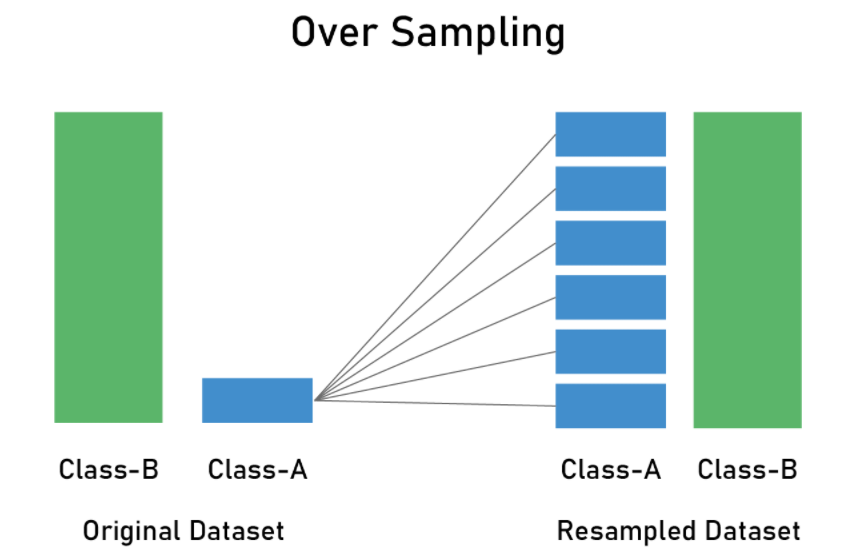

- **Undersampling**: Decide how many times the sample size of the minority class wants to be used and perform sampling with replacement in the minority class and sampling without replacement in the majority class. These methods delete instances from the over-represented class (majority class) in different ways. The most obvious way is to do delete instances randomly.

Below is a visualized process of how undersampling works:

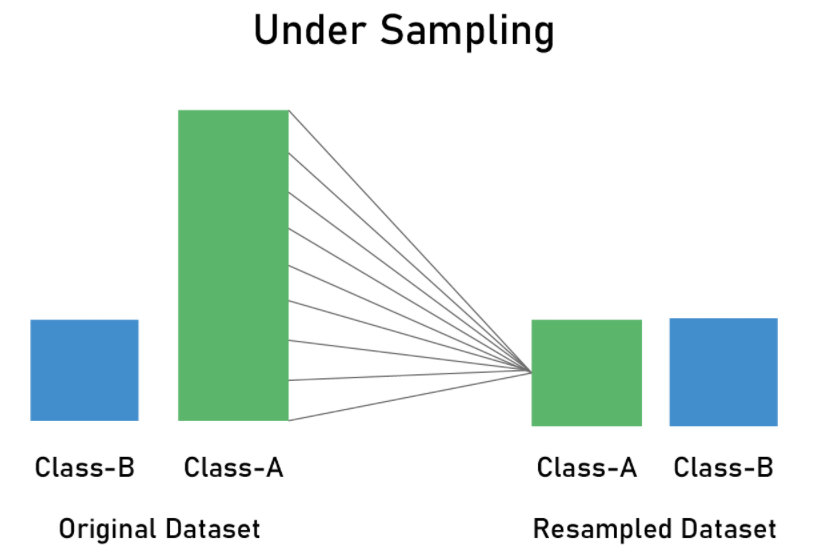

Although these techniques generally do work well, they do have some disadvantages:
- If we duplicate random records from the minority class to do oversampling, this will cause overfitting. (Oversampling)
- By undersampling and removing random records from the majority class, you risk losing some important information for the machine learning algorithm to use while training and predicting. (Undersampling)

Let's start with undersampling

## Undersampling

### Random Undersampling

We could use RandomUnderSampler() method to do the undersampling job. Here we can specify a few parameters inside the Object:
- **sampling_strategy**: this parameter can be used to tell the object how to perform undersampling on our dataset. It can be "majority" to resample only the majority class, "not_minority" to resample all classes but the minority class. If we leave it empty, it will be set default, which stands for "not minority".


- **return_indices**: A boolean parameter on whether to return the indices of the remove instances or not. By default, it is set to False.
- **random_state**:  An integer that controls the randomness of the procedure, which allow us to reproduce the results.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# create the object.
under_sampler = RandomUnderSampler() 


# fit the object to the training data.
x_under, y_under = under_sampler.fit_sample(X_train, y_train)

# See how data ia being balanced
print('Resampled dataset shape %s' % Counter(y_under))

Resampled dataset shape Counter({0: 328, 1: 328})


### NearMiss Undersampling

The basics of the NearMiss algorithms include the following:
1. The method starts by calculating the distances between all instances of the majority class and the instances of the minority class.
2. Then k instances of the majority class that have the smallest distances to those in the minority class are selected to be retained.
3. If there are n instances in the minority class, NearMiss will result in k × n instances of the majority class.

Below is a visualization process of Near Miss Undersampling:


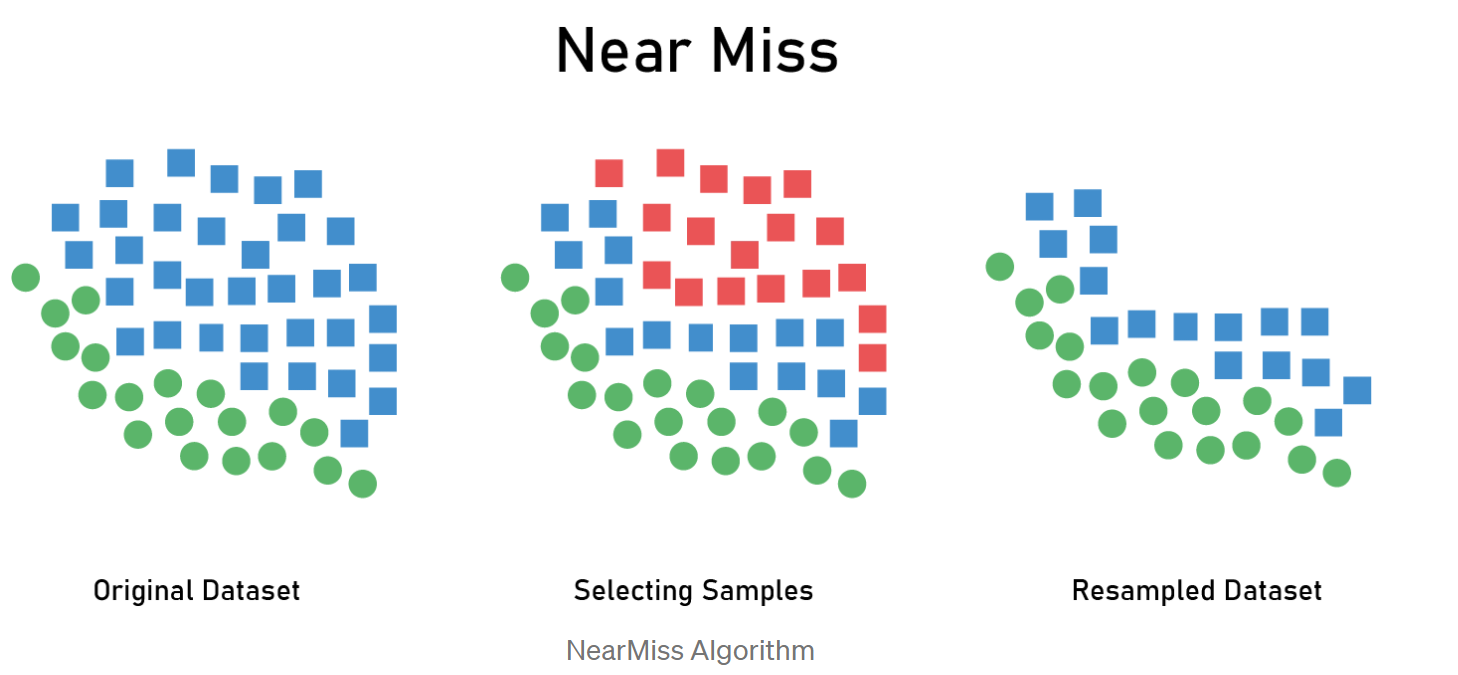

We could use NearMiss() method to do the undersampling job. Here we can specify a few parameters inside the Object:

- **version**: Note that we could set parameter **version** to 1, 2 or 3, which have different versions of this algorithm:
 - NearMiss-1 chooses instances of the majority class where their average distances to the three closest instances of the minority class are the smallest.

 - NearMiss-2 uses the three farthest samples of the minority class.

 - NearMiss-3 picks a given number of the closest samples of the majority class for each sample of the minority class.

- **n_neighbors**: NearMiss-3 algorithm start by a phase of re-sampling. This parameter correspond to the number of neighbours selected create the subset in which the selection will be performed. By default, it's 3

In [ ]:
from imblearn.under_sampling import NearMiss

# create the object with auto
near = NearMiss(version=1) # let's choose the version 1 here, but you could switch it to different versions


# fit the object to the training data.
x_under_near, y_under_near = near.fit_sample(X_train, y_train)

# See how data is being balanced
print('Resampled dataset shape %s' % Counter(y_under_near))

Resampled dataset shape Counter({0: 328, 1: 328})


### Tomek links Undersampling
Tomek links are pairs of very close instances that belong to different classes. They’re samples near the borderline between classes. By removing the examples of the majority class of each pair, we increase the space between the two classes and move toward balancing the dataset by deleting those points.

Below is a visualization process of Tomek links:
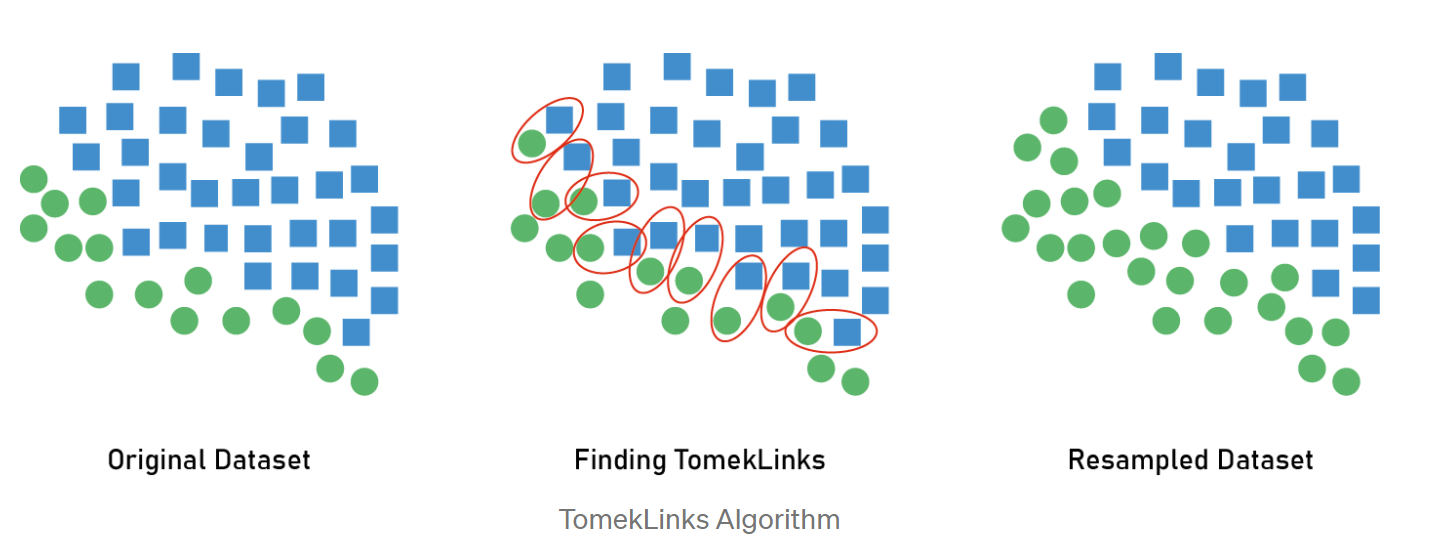


We could use TomekLinks() method to do the undersampling job. Here we can specify a few parameters inside the Object:
- **sampling_strategy**: this parameter can be used to tell the object how to perform undersampling on our dataset. It can be "majority" to resample only the majority class, "not_minority" to resample all classes but the minority class. "not majority" resample all classes but the majority class, and "all" to resample all classes. If we leave it empty, it will be set default, which stands for "not minority". 

In [ ]:
# import the TomekLinks object.
from imblearn.under_sampling import TomekLinks

# set sampling_strategy = 'majority' when initialize the object
tomek_links = TomekLinks(sampling_strategy = 'majority')


# fit the object to the training data.
x_tomek, y_tomek = tomek_links.fit_sample(X_train, y_train)

# See how data is being balanced
print('Resampled dataset shape %s' % Counter(y_tomek))   #199364 

Resampled dataset shape Counter({0: 199016, 1: 328})


### Cluster Centroids Undersampling
The idea of udersampling with cluster centroids is that we basically remove the unimportant instance from the majority class. To decide whether an instance is important or not, we use the concept of clustering on the geometry of the feature space.

Clustering is an unsupervised learning approach, in which clusters are creating encircling data points belonging.

We will use it only to find cluster centroid that are obtained by averaging feature vector for all the features over the data points.

After finding the cluster centroid of the majority class, we decide the following:

- The instance belonging to the cluster (majority class), which is farthest from the cluster centroid in the feature space, is considered to be the most unimportant instance.
- The instance belonging to the majority class, which is nearest to the cluster centroid in the feature space, is considered to be the most important instance.

Below is the visualization process of how it works:

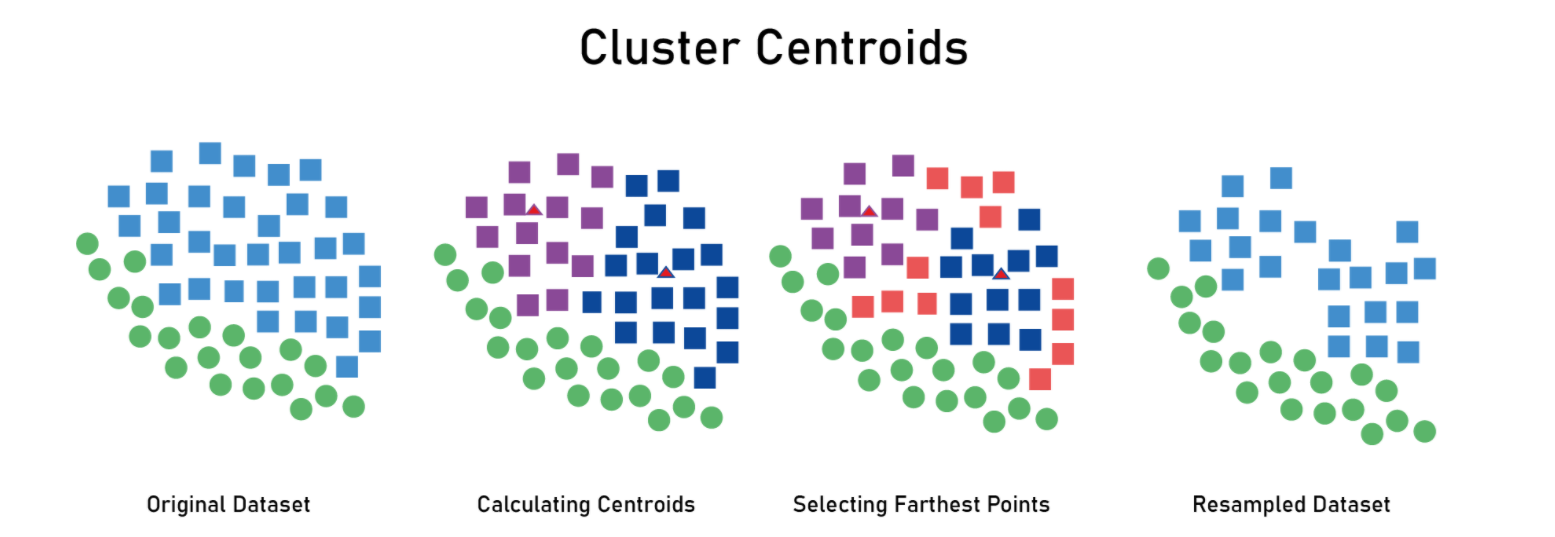

We could use ClusterCentroids() method to do the undersampling job. Here we can specify a few parameters inside the Object:

- **sampling_strategy**: this parameter can be used to tell the object how to perform undersampling on our dataset. It can be "majority" to resample only the majority class, "not minority" to resample all classes but the minority class. "not majority" resample all classes but the majority class, and "all" to resample all classes. If we leave it empty, it will be set default, which stands for "not minority". Note that the number of samples will not be equal in each. We could also use the a dictionary to set keys corresponding to the targeted classes, and the values corresponding to the desired number of samples for each targeted class.
- **estimator**: An object that performs the clustering process for this method—K-Means is the default here

In [ ]:
# import the ClusterCentroids object.
from imblearn.under_sampling import ClusterCentroids

# instantiate the object with the right ratio strategy.
cluster_centroids  = ClusterCentroids(sampling_strategy='auto') 


# fit the object to the training data.
x_cluster, y_cluster = cluster_centroids.fit_sample(X_train, y_train)

# See how data is being balanced
print('Resampled dataset shape %s' % Counter(y_cluster))

Resampled dataset shape Counter({0: 328, 1: 328})


### ENN Undersampling

ENN stands for Edited Nearest Neighbor Rule. This technique removes any instance from the majority class whose class label is different from the class label of at least two of its three nearest neighbors. In general terms, it’s near or around the borderline of different classes.

The point here is to increase the classification accuracy of minority instances rather than majority instances.

We could use EditedNearestNeighbours(). Note that we could also pass a dictionary to sampling_strategy

In [ ]:
# import the EditedNearestNeighbours object.
from imblearn.under_sampling import EditedNearestNeighbours


# create the object to resample the majority class.
enn = EditedNearestNeighbours(sampling_strategy= 'majority')


# fit the object to the training data.
x_enn, y_enn = enn.fit_sample(X_train, y_train)

# See how data is being balanced
print('Resampled dataset shape %s' % Counter(y_enn))

Resampled dataset shape Counter({0: 198921, 1: 328})


## Test each undersampling method

Next, let's apply logistic regression to test the classification report results for each under sampling methods we applied

In [ ]:
def logistic_regression(X_train,y_train, method):
  # create the model
  lr = LogisticRegression()

  # fit the data
  lr.fit(X_train, y_train)

  # make predictions
  lr_pred = lr.predict(X_test)

  # get the classification report
  print(f'{method}: ')
  print('\n')
  labels = ['No Fraud', 'Fraud']
  print(classification_report(y_test, lr_pred, target_names=labels))

In [ ]:
X_train.shape

(199364, 30)

In [ ]:
undersampling_methods = ['Without Sampling','Random Undersampling', 'NearMiss Undersampling', 'Tomek Links Undersampling', 'Cluster Centroids Undersampling', 'Edited Nearest Neighbor']

# X data from all methods
X_train_data = [X_train,x_under, x_under_near, x_tomek, x_cluster, x_enn]

# y data from all methods
y_train_data = [y_train, y_under, y_under_near, y_tomek, y_cluster, y_enn]


# loop into these lists and run the method:
for X, y, method in zip(X_train_data, y_train_data, undersampling_methods):
  logistic_regression(X,y, method)


Without Sampling: 


              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     85279
       Fraud       0.87      0.57      0.69       164

    accuracy                           1.00     85443
   macro avg       0.93      0.79      0.85     85443
weighted avg       1.00      1.00      1.00     85443

Random Undersampling: 


              precision    recall  f1-score   support

    No Fraud       1.00      0.95      0.97     85279
       Fraud       0.03      0.88      0.06       164

    accuracy                           0.95     85443
   macro avg       0.52      0.91      0.52     85443
weighted avg       1.00      0.95      0.97     85443

NearMiss Undersampling: 


              precision    recall  f1-score   support

    No Fraud       1.00      0.43      0.61     85279
       Fraud       0.00      0.96      0.01       164

    accuracy                           0.43     85443
   macro avg       0.50      0.70      0.31     85443
w

**What do you find?**

We can see that for each method, we increase the recall score comparing to the original model, with nearmiss achieving 93% for minority class

## Oversampling

### Random Oversampling
Random oversampling randomly duplicate records from the minority class. Try this technique when you don’t have a lot of data.
Random oversampling simply replicates random minority class examples. It’s known to increase the likelihood of overfitting, which is a major drawback.

We could use RandomOverSampler() method to do the oversampling job. Here we can specify a few parameters inside the Object:
- **sampling_strategy**: all parameters work the same way as previous, the only difference is that by default, it's "not majority". We could also pass a dictionary as before

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# create the object.
over_sampler = RandomOverSampler() 


# fit the object to the training data.
x_over, y_over = over_sampler.fit_sample(X_train, y_train)

# See how data ia being balanced
print('Resampled dataset shape %s' % Counter(y_over))

Resampled dataset shape Counter({0: 199036, 1: 199036})


### SMOTE Oversampling
 SMOTE is effective avoiding moderl overfitting.
 To create a synthetic instance, SMOTE finds the K-nearest neighbors of each minority instance, randomly selects one of them and then calculates linear interpolations to produce a new minority instance in the neighborhood. It can be also explained by changing this instance features one at a time by a random amount. Thus, new points are added between the neighbors.

 Below is a visualization process of how it works:
 
 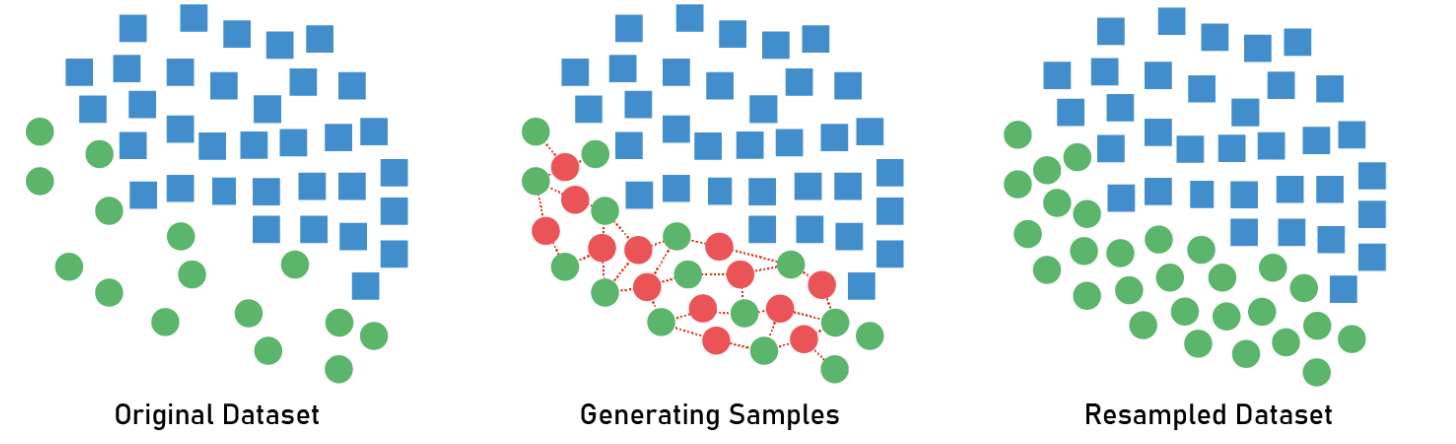

In [ ]:
from imblearn.over_sampling import SMOTE

# create the object.
smote = SMOTE() 

# fit the object to the training data.
x_smote, y_smote = smote.fit_sample(X_train, y_train)

# See how data ia being balanced
print('Resampled dataset shape %s' % Counter(y_smote))

Resampled dataset shape Counter({0: 199036, 1: 199036})


### ADASYN Oversampling
ADASYN stands for Adaptive Synthetic sampling, and as SMOTE does, ADASYN generates samples of the minority class. But here, because of their density distributions, this technique receives wide attention.

Its purpose is to generate data for minority class samples that are harder to learn, as compared to those minority samples that are easier to learn.

ADASYN uses KNN to measure all minority instances, then calculates the class ratio of the minority and majority instances to create new samples. By Repeating this process, we will adaptively shift the decision boundary to focus on those samples that are hard to learn.

**The major difference between SMOTE and ADASYN is the difference in the generation of synthetic sample points for minority data points. In ADASYN, we consider a density distribution which thereby decides the number of synthetic samples to be generated for a particular point, whereas in SMOTE, there is a uniform weight for all minority points.**

In [ ]:
# import the ADASYN object.
from imblearn.over_sampling import ADASYN

# create the object 
adasyn = ADASYN() 

# Split the data into X ,y
X = df.drop('Class', axis=1)
y = df['Class']

# fit the object to the training data.
x_adasyn, y_adasyn = adasyn.fit_sample(X, y)

# See how data ia being balanced
print('Resampled dataset shape %s' % Counter(y_adasyn))

Resampled dataset shape Counter({0: 284315, 1: 284292})


## Test each oversampling method

In [ ]:
oversampling_methods = ['Random Oversampling', 'SMOTE Oversampling', 'ADASYN Oversampling']

# X data from all methods
X_over_data = [x_over, x_smote, x_adasyn]

# y data from all methods
y_over_data = [y_over, y_smote, y_adasyn]

# run the logistice function again, and inspect the result:
for x_train_set, y_train_set, method in zip(X_over_data, y_over_data, oversampling_methods):
  logistic_regression(x_train_set, y_train_set, method)

Random Oversampling: 


              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     85279
       Fraud       0.07      0.88      0.13       164

    accuracy                           0.98     85443
   macro avg       0.54      0.93      0.56     85443
weighted avg       1.00      0.98      0.99     85443

SMOTE Oversampling: 


              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     85279
       Fraud       0.07      0.87      0.12       164

    accuracy                           0.98     85443
   macro avg       0.53      0.92      0.56     85443
weighted avg       1.00      0.98      0.99     85443

ADASYN Oversampling: 


              precision    recall  f1-score   support

    No Fraud       1.00      0.91      0.95     85279
       Fraud       0.02      0.94      0.04       164

    accuracy                           0.91     85443
   macro avg       0.51      0.92      0.50     85443
wei

## Combining both Oversampling & Undersampling

Aside from doing oversampling & undersampling seperately, we could also combine these 2 techniques to get better sampling results. Let's introduce 2 ways:
- SMOTE & Tomek Links
- SMOTE & ENN

### SMOTE & Tomek Links 

We could use SMOTETomek() to do it.

- **sampling_strategy**: It can be "minority" to resample only the minority class, "not minority" to resample all classes but the minority class, "not majority" to resample all classes but the majority class, and "all" to resample all classes. If we leave it empty, it will be set default, which stands for "not majority". We could also use the a dictionary to set keys corresponding to the targeted classes, and the values corresponding to the desired number of samples for each targeted class.

In [ ]:
# import the SMOTETomek.
from imblearn.combine import SMOTETomek

# create the  object, and use the automatic strategy by setting sampling_strategy ='auto'
smotemek = SMOTETomek(sampling_strategy='auto')

# fit the object to our training data.
x_smt, y_smt = smotemek.fit_sample(X_train, y_train)

# See how data ia being balanced
print('Resampled dataset shape %s' % Counter(y_smt))

Resampled dataset shape Counter({0: 199036, 1: 199036})


### SMOTE & ENN (Edited Nearest Neighbor)

We could use SMOTEENN() to resample our data. Note that **sampling_strategy** works the same way as SMOTETomek()

In [ ]:
# import the SMOTETomek.
from imblearn.combine import SMOTEENN

# create the  object with the automatic sampling strategy.
smoenn = SMOTEENN(sampling_strategy='auto')

# fit the object to our training data.
x_smoenn, y_smoenn = smoenn.fit_sample(X_train, y_train)

# See how data ia being balanced
print('Resampled dataset shape %s' % Counter(y_smoenn))

Resampled dataset shape Counter({1: 199036, 0: 198753})


## Test each method with both undersampling & oversampling techniques

In [ ]:
OverUndersamplingCombined= ['SMOTE & Tomek Links', 'SMOTE & ENN']

# X data from all methods
X_combined_data = [x_smt, x_smoenn]

# y data from all methods
y_combined_data = [y_smt, y_smoenn]

# test all data using the logistic function we defined:
for x_train_set, y_train_set, method in zip(X_combined_data, y_combined_data, OverUndersamplingCombined):
  logistic_regression(x_train_set, y_train_set, method)

SMOTE & Tomek Links: 


              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     85279
       Fraud       0.07      0.87      0.12       164

    accuracy                           0.98     85443
   macro avg       0.53      0.92      0.56     85443
weighted avg       1.00      0.98      0.99     85443

SMOTE & ENN: 


              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     85279
       Fraud       0.06      0.87      0.12       164

    accuracy                           0.98     85443
   macro avg       0.53      0.92      0.55     85443
weighted avg       1.00      0.98      0.99     85443



## Get all precision & recall score

Let's get all precison scores and recall scores in one place. First, let's write a function to return both scores per method

In [ ]:
def get_precision_recall(X_train,y_train):
  # create the model
  lr = LogisticRegression()

  # fit the data
  lr.fit(X_train, y_train)

  # make predictions
  lr_pred = lr.predict(X_test)

  # get both precision score & recall score
  precision = "{0:.0%}".format(precision_score(y_test, lr_pred))
  recall = "{0:.0%}".format(recall_score(y_test, lr_pred))

  return precision, recall



In [ ]:
# Wrap all methods' name into a single list
all_methods = ['Without resampling', 'Random Undersampling', 'NearMiss Undersampling', 'TomekLinks Undersampling', 'Cluster Centroids Undersampling','ENN Undersampling',
               'Random Oversampling', 'SMOTE Oversampling', 'ADASYN Oversampling', 'SMOTE & TomekLinks', 'SMOTE & ENN']


# Define the X data and y data
X_datas = [X_train, x_under, x_under_near, x_tomek, x_cluster, x_enn, x_over, x_smote, x_adasyn, x_smt, x_smoenn]
y_datas = [y_train, y_under, y_under_near, y_tomek, y_cluster, y_enn, y_over, y_smote, y_adasyn, y_smt, y_smoenn]


precision_scores = []
recall_scores = []

for x_train_set, y_train_set in zip(X_datas, y_datas):
  precision_scores.append(get_precision_recall(x_train_set, y_train_set)[0])
  recall_scores.append(get_precision_recall(x_train_set, y_train_set)[1])

In [ ]:
methods = {'Without Resampling': all_methods[0],
           'UnderSampling': all_methods[1:6],
           'OverSampling': all_methods[6:9],
           'Oversampling & Undersampling': all_methods[9:]}


data_tuples = list(zip(all_methods,precision_scores,recall_scores))

df_com = pd.DataFrame(data_tuples, columns = ['Methods', 'Precisions', 'Recalls'])
df_com

,Methods,Precisions,Recalls
0,Without resampling,87%,57%
1,Random Undersampling,3%,88%
2,NearMiss Undersampling,0%,96%
3,TomekLinks Undersampling,87%,58%
4,Cluster Centroids Undersampling,4%,88%
5,ENN Undersampling,87%,59%
6,Random Oversampling,7%,88%
7,SMOTE Oversampling,7%,87%
8,ADASYN Oversampling,2%,94%
9,SMOTE & TomekLinks,7%,87%


## Use Penalize Algorithms

We could also try to do cost-sensitive training, which is penalized learning algorithms. One of these is **Penalized Support Vector Machine**. As we do so, we increase the cost of classification mistakes on the minority class.

During training, we can use the argument **class_weight='balanced'**  to penalize mistakes on the minority class by an amount proportional to how under-represented it is.

We also want to include the argument **probability=True**  if we want to enable probability estimates for SVM algorithms.

*-----**Warning**-----*

- When you train the model, you should consider implementing a series of strict steps to get a good result, which are similar to steps being demonstrated in original fraud detection notebook . Here we mainly focus on dealing with the imbalanced data, that's why we simply apply the algorithm to complete it.

- Whether you will get a good results by using penalized algorithms often **depends on your data**. We are introducing you the method here, but you should be careful deciding if you are going to use them if you have a heavily imbalanced data, as sometimes it could worsen your results.

Let's first try to use a standard SVC

In [ ]:
from sklearn.svm import SVC


# Create the model
svc = SVC()

# Fit the model
svc.fit(X_train, y_train)

# Make predictions
svc_pred = svc.predict(X_test)

# get the accuracy score
print(accuracy_score(y_test, svc_pred))

# get classification reports
labels = ['No Fraud', 'Fraud']
print(classification_report(y_test, svc_pred, target_names=labels))

0.9993328885923949
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     85279
       Fraud       0.95      0.69      0.80       164

    accuracy                           1.00     85443
   macro avg       0.97      0.84      0.90     85443
weighted avg       1.00      1.00      1.00     85443



This time, we use Penalized Support Vector Machine

In [ ]:
# Create the svm model, this time, we set class_weight = 'balanced' to penalize the minority
svc = SVC(class_weight='balanced')


# fit the model
svc.fit(X_train, y_train)

# make predictions
svc_pred = svc.predict(X_test)

# get the accuracy score
print(accuracy_score(y_test, svc_pred))

labels = ['No Fraud', 'Fraud']
print(classification_report(y_test, svc_pred, target_names=labels))

0.9966176281263532
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     85279
       Fraud       0.33      0.74      0.46       164

    accuracy                           1.00     85443
   macro avg       0.67      0.87      0.73     85443
weighted avg       1.00      1.00      1.00     85443



Also, Logistic regression has options for us to penalize the minority class

In [ ]:
# Create the penalized logistic regression model
lr = LogisticRegression(class_weight='balanced')


# fit the data
lr.fit(X_train, y_train)

#make predictions
lr_pred = lr.predict(X_test)

# get classification reports
labels = ['No Fraud', 'Fraud']
print(classification_report(y_test, lr_pred, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     85279
       Fraud       0.07      0.88      0.13       164

    accuracy                           0.98     85443
   macro avg       0.54      0.93      0.56     85443
weighted avg       1.00      0.98      0.99     85443



Compare this to our original logistic regression model before, did you notice something?

## Change the performance metrics

Also, changing the performance metrics is also helpful sometimes. Usually, the accuracy is misleading, which is trhe not ideal metric to use when dealing with imbalanced datasets. Other metrics have been desgined for such a case, including
- Confusion Matrix
- Precison & Recall
- F1 Score
- ROC Curves

Please refer to Fraud Detection notebook, where each of them has been implemented in detail.

# Good job!